# UCB MFE Python Pre-Program Course - Homework 3
# Submitted by Wenhao Luan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

# Step 1: Data Loading

In [2]:
df = pd.read_csv('hw3.csv', index_col='ts')

In [3]:
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


# Step 2: Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2667 entries, 2021-12-02 14:00:00 to 2021-12-06 07:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2667 non-null   float64
 1   high       2163 non-null   float64
 2   low        2378 non-null   float64
 3   close      2531 non-null   float64
 4   volume     2667 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2667 non-null   object 
 7   chain      2667 non-null   object 
dtypes: float64(6), object(2)
memory usage: 187.5+ KB


In [5]:
df['token'].value_counts()

BTC                                   323
COMP                                  322
CRV                                   318
SOL                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">SOL</span>      16
<span name="tokenName">AAVE</span>     16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64

In [6]:
df['chain'].value_counts()

ETH     1663
BTC      337
SOL      334
USDT     333
Name: chain, dtype: int64

In [7]:
df.duplicated().sum()

307

In [8]:
def plotAllTokens( df ):
    tokens_in_df = df.token.unique()
    fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))
    idx = 0
    for label, df_token in df[['token', 'close']].groupby('token'):
        df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
        axes[idx // 2, idx % 2].legend()
        idx += 1
    return fig, axes

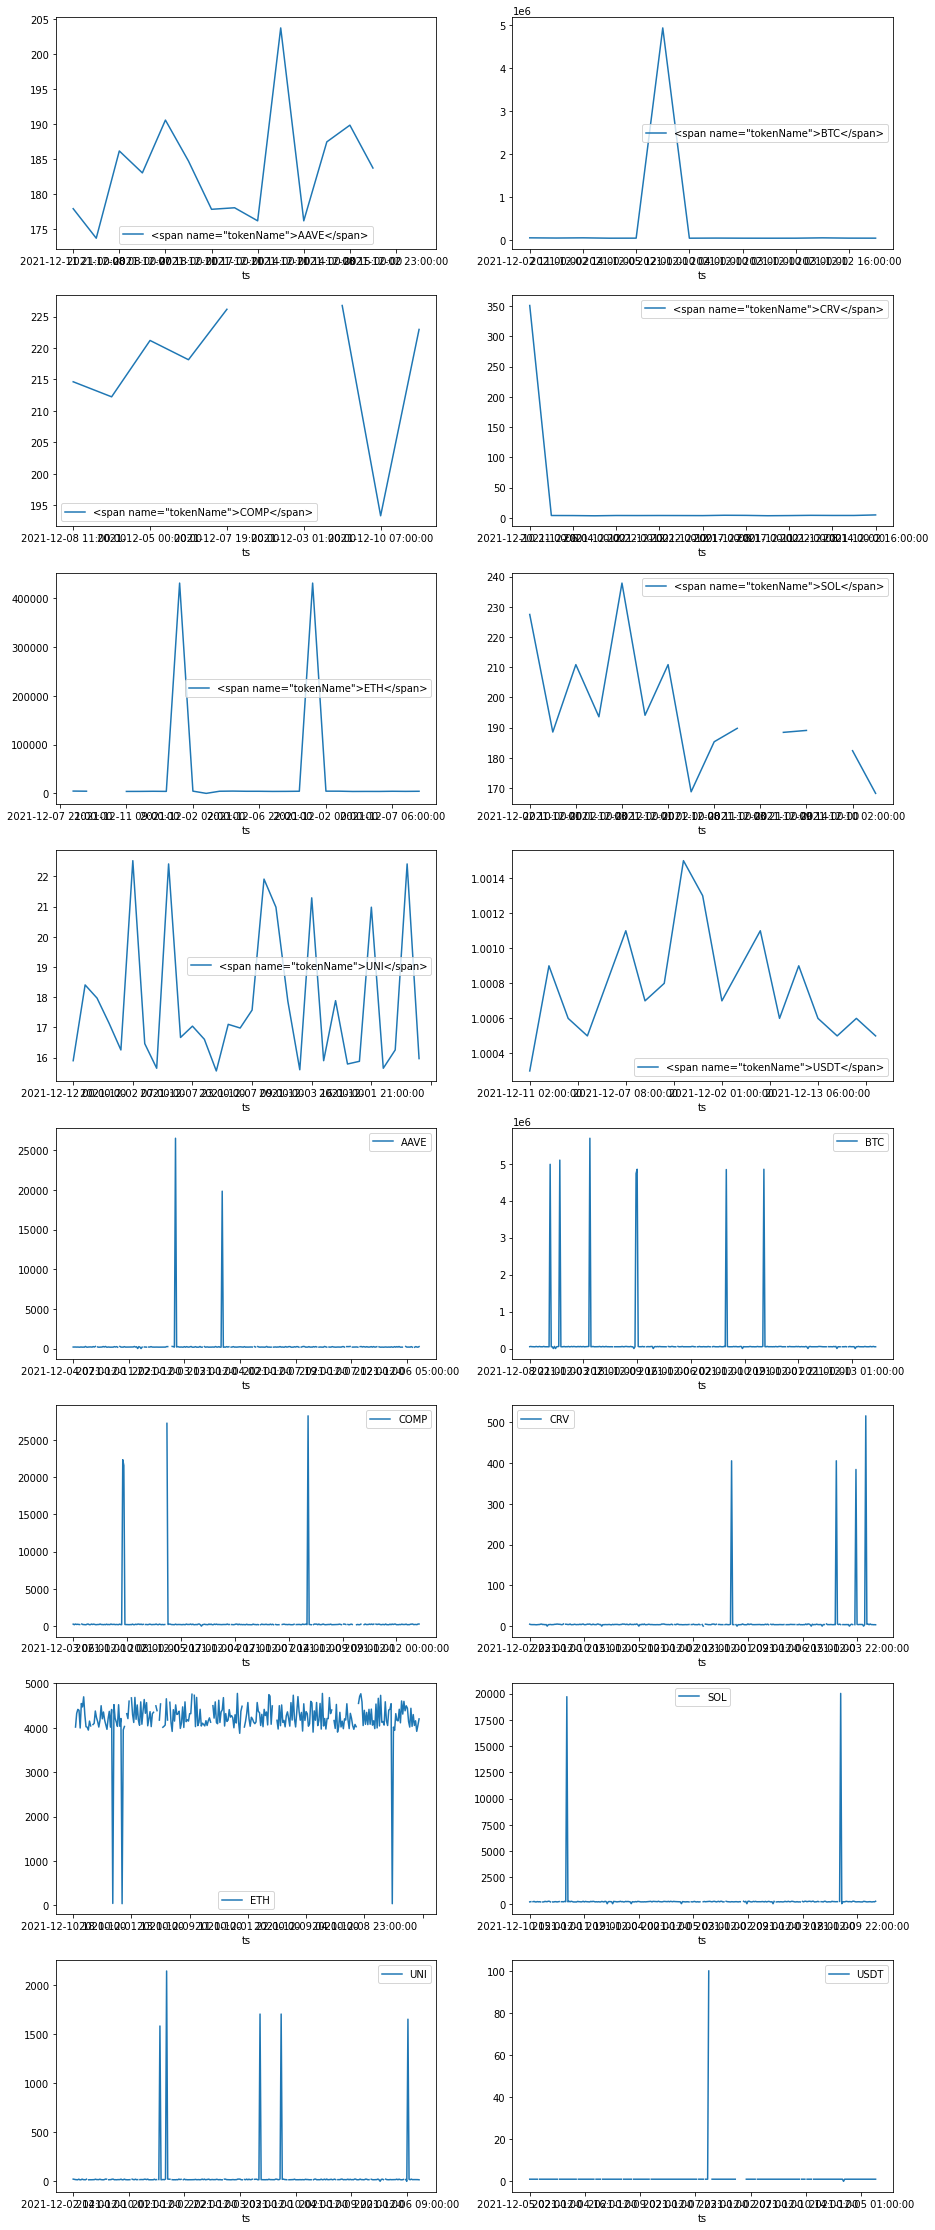

In [9]:
_  = plotAllTokens( df )

# Step 3: Data Cleaning

### 1. Drop duplicates

In [10]:
df = df.drop_duplicates()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2360 entries, 2021-12-02 14:00:00 to 2021-12-06 07:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2360 non-null   float64
 1   high       1910 non-null   float64
 2   low        2104 non-null   float64
 3   close      2244 non-null   float64
 4   volume     2360 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2360 non-null   object 
 7   chain      2360 non-null   object 
dtypes: float64(6), object(2)
memory usage: 165.9+ KB


### 2. Format token name

In [12]:
token_selector = df['token'].str.contains('<span name="tokenName">')
df.loc[token_selector, 'token'] = df.loc[token_selector, 'token'].str.extract('<span name\=\"tokenName\">(.|\n)*?<\/span>')

In [13]:
df['token'].value_counts()

COMP    286
BTC     283
SOL     281
AAVE    280
CRV     279
USDT    278
UNI     270
ETH     270
Name: token, dtype: int64

### 3. Impute missing close prices

<AxesSubplot:ylabel='ts'>

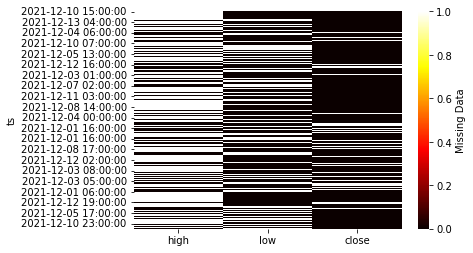

In [14]:
missing_selector = pd.isnull(df[['high', 'low', 'close']]).sum(axis=1) > 0
sns.heatmap(df[missing_selector][['high', 'low', 'close']].isna(), cmap='hot', cbar_kws={'label': 'Missing Data'})

In [15]:
df[pd.isnull(df[['high', 'low', 'close']]).sum(axis=1) == 3]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-08 21:00:00,216.56,NaN,NaN,NaN,2255.276,NaN,COMP,ETH


As only all open prices are available and any combination of missing values across high, low and close prices are possible, we shall use below heuristic for missing close price imputation:

| high | low | imputation rule         |
| ---- | --- | ---------------         |
| Y    | Y   | close = (high + low)/2  |
| Y    | N   | close = (open + high)/2 |
| N    | Y   | close = (open + low)/2  |
| N    | N   | close = open            |

In [32]:
def imputeValues(df, missing_selector=None):
    df = df.copy()
    missing_selector = missing_selector if missing_selector is not None else df['close'].isnull()
    
    # Case 1: Both high and low are available
    selector =  missing_selector & ~df['high'].isnull() & ~df['low'].isnull()
    df.loc[selector, 'close'] = 0.5 * (df.loc[selector, 'high'] + df.loc[selector, 'low'])
    
    #Case 2: High is available but low is unavailable
    selector = missing_selector & ~df['high'].isnull() & df['low'].isnull()
    df.loc[selector, 'close'] = 0.5 * (df.loc[selector, 'high'] + df.loc[selector, 'open'])
    
    #Case 3: High is unavailable but high is unavailable
    selector = missing_selector & df['high'].isnull() & ~df['low'].isnull()
    df.loc[selector, 'close'] = 0.5 * (df.loc[selector, 'open'] + df.loc[selector, 'low'])
    
    #Case 4: Neither high or low is available
    selector = missing_selector & df['low'].isnull()
    df.loc[selector, 'close'] = df.loc[selector, 'open']
    
    return df

In [17]:
df = imputeValues(df)

Let's verify the imputation results:

In [19]:
df['close'].isnull().sum()

0

### 4. Normalize outliers

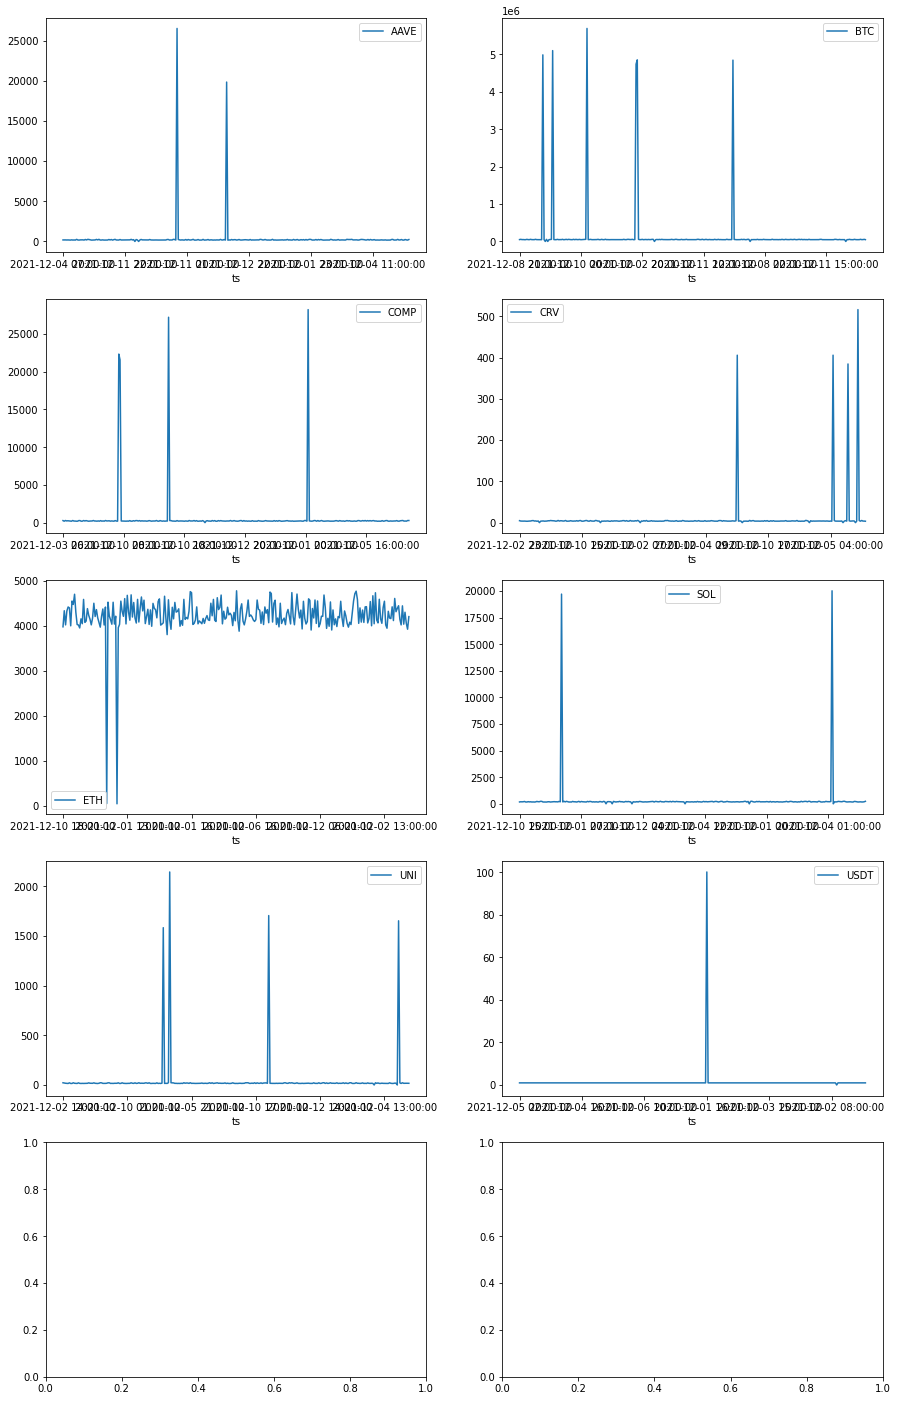

In [20]:
_ = plotAllTokens( df )

All tokens have outliers as shown in the plots above. We shall normalize them in the same way as we impute missing values.

Here we define an outlier as a data point whose close price is greater than 2x higher or lower than the open price.

In [23]:
df.loc[(df.close / df.open >= 2) | (df.close / df.open <= 0.5)]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-10 21:00:00,3.4600,3.5100,3.4600,3.510000e+02,1.080245e+05,NaN,NaN,ETH
2021-12-12 14:00:00,49542.3900,NaN,49534.7100,4.983812e+06,3.426704e+02,NaN,BTC,BTC
2021-12-03 12:00:00,56891.7000,57209.7000,56858.0200,5.703374e+02,1.897550e+02,NaN,BTC,BTC
2021-12-07 07:00:00,50941.5000,51272.8300,50936.0500,5.122500e+02,3.124719e+02,NaN,BTC,BTC
2021-12-06 01:00:00,3.6302,3.6365,3.4638,3.575800e-02,4.227913e+05,NaN,CRV,ETH
2021-12-07 08:00:00,51224.9900,51398.2600,50883.3400,5.097338e+06,4.433800e+02,NaN,BTC,BTC
2021-12-07 18:00:00,197.0930,197.8000,194.3450,1.969890e+04,6.369084e+04,NaN,SOL,SOL
2021-12-08 01:00:00,223.8500,224.9800,220.3900,2.233300e+04,1.477532e+03,NaN,COMP,ETH
2021-12-08 12:00:00,214.8900,217.1000,212.3800,2.156800e+04,2.372441e+03,NaN,COMP,ETH


In [33]:
df = imputeValues(df, missing_selector=(df.close / df.open >= 2) | (df.close / df.open <= 0.5))

In [34]:
df.loc[(df.close / df.open >= 2) | (df.close / df.open <= 0.5)]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,


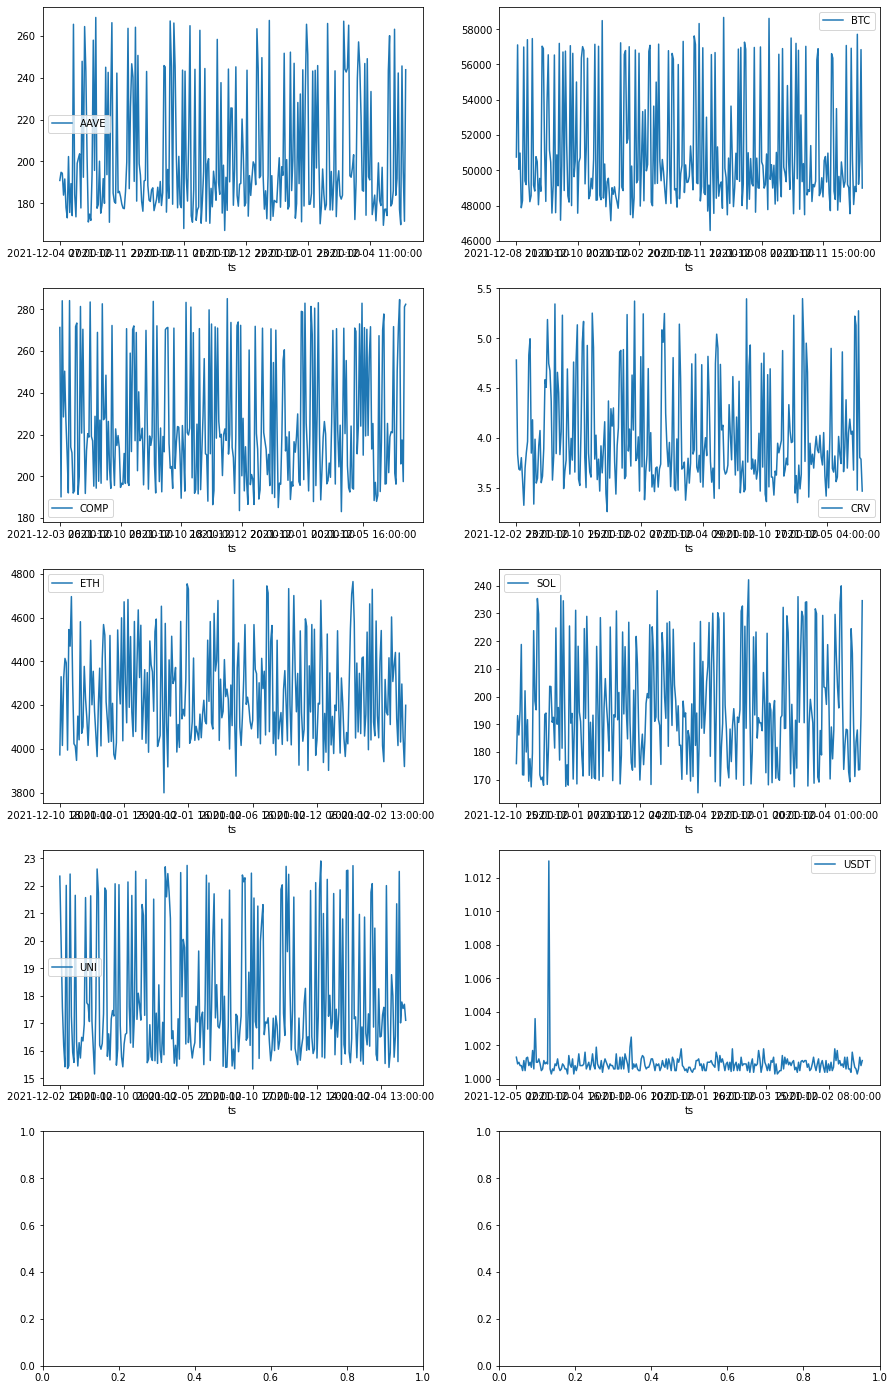

In [35]:
_ = plotAllTokens(df)

# Step 4: Calculation of volumeUSD

In [36]:
df.loc[:,'volumeUSD'] = df['volume'] * df['close']

In [44]:
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,7.041235e+05,UNI,ETH
2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,3.522644e+05,CRV,ETH
2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,1.296734e+07,SOL,SOL
2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,7.352023e+07,ETH,ETH
2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,1.341009e+07,SOL,SOL


In [41]:
total_volume_usd = df.groupby('token')['volumeUSD'].sum().sort_values(ascending=False)

<AxesSubplot:xlabel='token'>

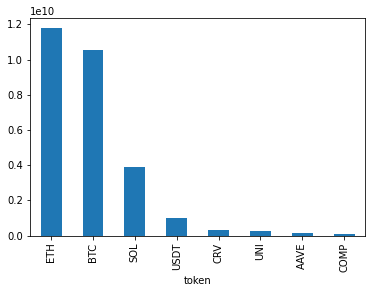

In [42]:
total_volume_usd.plot(kind='bar')